In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#Import the consolidated data set
file_path = "data\\3_intermediate\\int_texas_border_report.csv"

border_report = pd.read_csv(
    file_path, 
    parse_dates=['nibrs_start_date', 'report_year'], 
    date_format='%Y-%m-%d')

border_report.head()

,agency_name,county,population,nibrs_start_date,murder_and_nonnegligent_manslaughter,negligent_manslaughter,rape,robbery,assault,burglary,...,report_year,agency_type,nibrs_eligible_months,has_preliminary_nibrs_reporting,nibrs_contribution_percentage,cohort_year,cohort_quarter,cohort,adoption_status,adoption_status_numeric
0,ALAMO PD,Hidalgo County,19351,2018-08-01,0,0,0,0,0,0,...,2017,Police Department,0,False,NaN,2018,3,2018Q3,early,1
1,ALPINE PD,Brewster County,5983,2020-04-01,0,0,0,0,0,0,...,2017,Police Department,0,False,NaN,2020,2,2020Q2,early,1
2,ALTON PD,Hidalgo County,17432,2019-09-01,0,0,0,0,0,0,...,2017,Police Department,0,False,NaN,2019,3,2019Q3,early,1
3,ANTHONY PD,El Paso County,5681,2020-12-01,0,0,0,0,0,0,...,2017,Police Department,0,False,NaN,2020,4,2020Q4,early,1
4,BREWSTER CO SO,Brewster County,3196,2015-01-01,1,0,2,0,19,4,...,2017,Sheriff's Office,12,False,91.67,2015,1,2015Q1,early,1


In [3]:
# Convert datetime columns to numeric representation
border_report['nibrs_start_date'] = border_report['nibrs_start_date'].astype('int64')
border_report['report_year'] = border_report['report_year'].astype('int64')

# The 'nibrs_contribution_percentage' column is used to calculate the weighted contribution of each agency to the total crime count.
# The 'nibrs_contribution_percentage' column is divided by 100 to convert the percentage to a decimal.
border_report['weighted_contribution'] = border_report['nibrs_contribution_percentage'].fillna(0) / 100

# Calculate the weighted contribution per year by summing the 'weighted_contribution'
active_agency_yearly_weights = border_report.groupby('report_year')['weighted_contribution'].sum().reset_index(name='weighted_active_agencies')

columns_to_drop = [
    'agency_name', 'agency_type', 'county', 'nibrs_start_date',
    'nibrs_contribution_percentage', 'cohort_quarter', 'adoption_status_numeric',
    'population', 'cohort', 'adoption_status', 'cohort_year',
    'has_preliminary_nibrs_reporting', 'months_reported', 'nibrs_eligible_months'
]

#Drop columns that are not needed for the analysis
total_crimes_by_year_temp = border_report.drop(columns_to_drop, axis=1)

# Aggregate total crime counts by year
total_crimes_by_year = total_crimes_by_year_temp.groupby(['report_year']).sum().reset_index()
total_crimes_by_year.head()

,report_year,murder_and_nonnegligent_manslaughter,negligent_manslaughter,rape,robbery,assault,burglary,larceny_theft,motor_vehicle_theft,arson,human_trafficking_commercial_sex_acts,human_trafficking_involuntary_servitude,weighted_contribution
0,2017,2,1,54,30,877,328,1451,126,2,0,0,10.5000
1,2018,6,5,140,218,5106,1372,8557,402,27,1,0,19.1806
2,2019,44,6,542,614,12405,3152,18609,1293,102,6,51,30.0499
3,2020,74,21,781,839,19101,3816,21701,1765,133,3,21,43.2499
4,2021,104,15,1310,859,29513,5282,28741,3015,201,4,64,59.1665


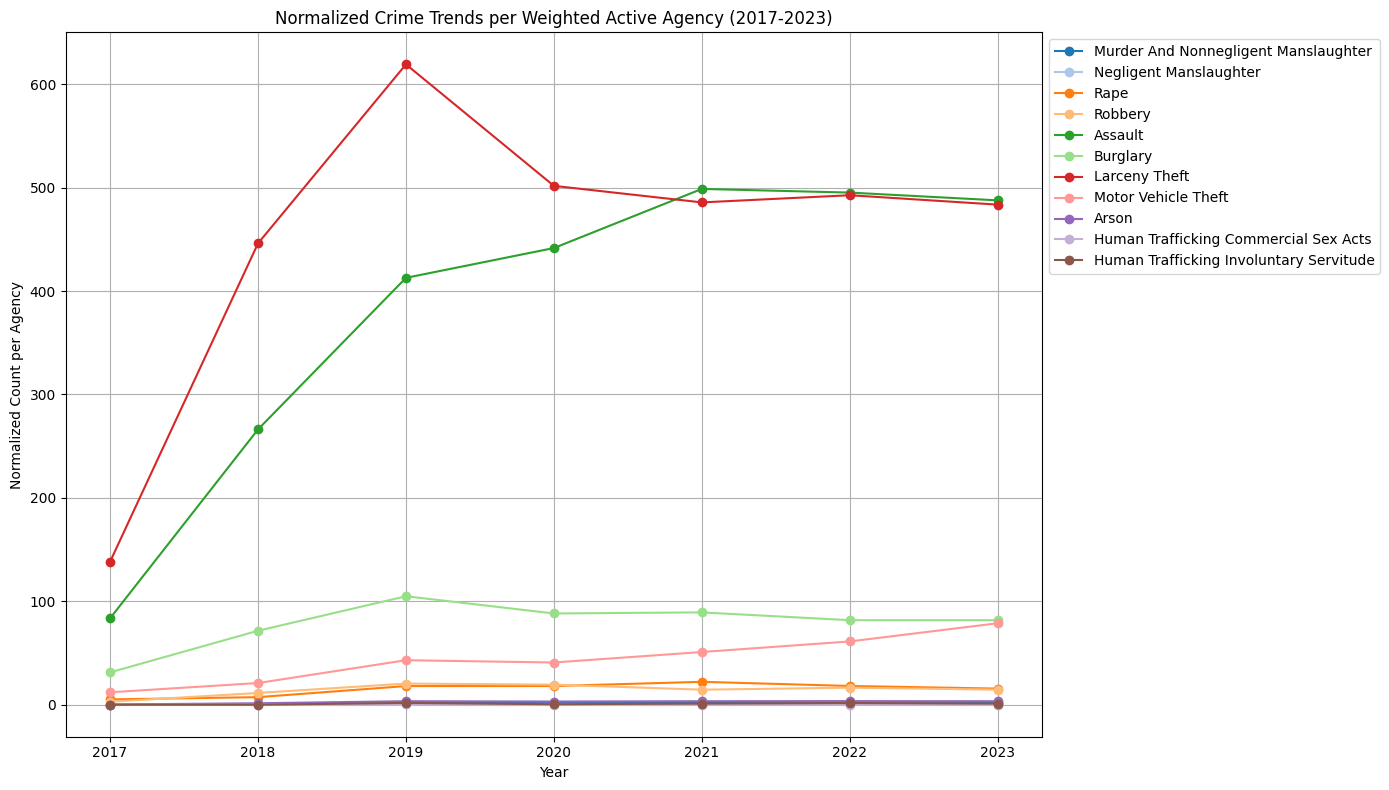

In [4]:
# List the NIBRS crime columns
all_relevant_crime_columns = [
    'murder_and_nonnegligent_manslaughter', 'negligent_manslaughter',
    'rape', 'robbery', 'assault', 'burglary', 'larceny_theft',
    'motor_vehicle_theft', 'arson', 'human_trafficking_commercial_sex_acts',
    'human_trafficking_involuntary_servitude'
]

# Normalizing the crime counts by the weighted active agencies
for crime in all_relevant_crime_columns:
    normalized_column_name = f'normalized_{crime}'
    if crime in border_report.columns:  # Ensure the crime column exists in the DataFrame
        #Divide the total number of crimes per year by the sum of the nibrs_contribution percentage
        total_crimes_by_year[normalized_column_name] = total_crimes_by_year[crime] / total_crimes_by_year['weighted_contribution']

# Visualization
plt.figure(figsize=(14, 8))
colors = mpl.colormaps.get_cmap('tab20')

for i, crime in enumerate(all_relevant_crime_columns):
    normalized_column_name = f'normalized_{crime}'
    if normalized_column_name in total_crimes_by_year.columns:  # Check if the normalized column exists in the data
        plt.plot(
            total_crimes_by_year['report_year'], 
            total_crimes_by_year[normalized_column_name],
            marker='o', 
            linestyle='-', 
            label=crime.replace('_', ' ').title(), 
            color=colors(i))

plt.title('Normalized Crime Trends per Weighted Active Agency (2017-2023)')
plt.xlabel('Year')
plt.ylabel('Normalized Count per Agency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Save the plot in the graphs folder
file_path = "graphs\\normalized_crime_trends.png"
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [5]:
#Inspect the nibrs_contribution_percentages and weighted_contribution columns
contribution_weights = border_report[['agency_name', 'report_year', 'nibrs_contribution_percentage', 'weighted_contribution']]
contribution_weights.head()


,agency_name,report_year,nibrs_contribution_percentage,weighted_contribution
0,ALAMO PD,2017,NaN,0.0000
1,ALPINE PD,2017,NaN,0.0000
2,ALTON PD,2017,NaN,0.0000
3,ANTHONY PD,2017,NaN,0.0000
4,BREWSTER CO SO,2017,91.67,0.9167


In [6]:
# Determine the count of eligible agencies per report year
# Agencies are eligible if their cohort year is <= the report year
eligible_agencies_per_year = border_report[border_report['cohort_year'] <= border_report['report_year']].groupby('report_year')['agency_name'].nunique().reset_index(name='eligible_agencies')

# Initialize a DataFrame to store the final data
yearly_crime_reports = pd.DataFrame()

# Loop through each crime type to gather necessary information
for crime in all_relevant_crime_columns:
    if crime in border_report.columns:  # Ensure the crime column is present in the data
        # For each crime, calculate the total occurrences (raw count) and the number of agencies reporting that crime per year
        crime_report_data = border_report.groupby('report_year').agg({crime: ['sum', lambda x: (x>0).sum()]}).reset_index()
        crime_report_data.columns = ['report_year', 'raw_count', 'reporting_agencies']  # Simplify column names
        crime_report_data['crime_type'] = crime  # Add crime type
        
        # Merge with eligible agencies data to add count of eligible agencies
        crime_report_data = pd.merge(crime_report_data, eligible_agencies_per_year, on='report_year')
        
        # Calculate normalized count based on the weighted active agencies already in normalized_data
        crime_report_data = pd.merge(crime_report_data, total_crimes_by_year[['report_year', f'normalized_{crime}']].rename(columns={f'normalized_{crime}': 'normalized_count'}), on='report_year', how='left')
        
        # Append to the final DataFrame
        yearly_crime_reports = pd.concat([yearly_crime_reports, crime_report_data], ignore_index=True)

# Reorder and select relevant columns for clarity
yearly_crime_reports = yearly_crime_reports[['report_year', 'crime_type', 'raw_count', 'normalized_count', 'eligible_agencies', 'reporting_agencies']]

# Convert 'crime_type' back to a more readable format
yearly_crime_reports['crime_type'] = yearly_crime_reports['crime_type'].str.replace('_', ' ').str.title()

#Export to csv
yearly_crime_reports.to_csv("data\\4_fact\\fct_yearly_crime_reports.csv", index=False)

# Display the DataFrame
yearly_crime_reports.head()

,report_year,crime_type,raw_count,normalized_count,eligible_agencies,reporting_agencies
0,2017,Murder And Nonnegligent Manslaughter,2,0.190476,7,2
1,2018,Murder And Nonnegligent Manslaughter,6,0.312816,18,4
2,2019,Murder And Nonnegligent Manslaughter,44,1.464231,32,10
3,2020,Murder And Nonnegligent Manslaughter,74,1.710987,47,13
4,2021,Murder And Nonnegligent Manslaughter,104,1.757751,75,20


In [7]:
#From graph_data_with_raw_counts, create a pivot table where the rows are the years, and the columns are crime types
normalized_data_per_year = yearly_crime_reports.pivot(index='report_year', columns='crime_type', values='normalized_count')

#Convert the pivot table to a DataFrame
normalized_data_per_year = normalized_data_per_year.reset_index()

#Join eligible_agencies_per_year to normalized_data_per_year on year
normalized_data_per_year = pd.merge(normalized_data_per_year, eligible_agencies_per_year, on='report_year')

#Move the eligible_agencies column to the second position
cols = normalized_data_per_year.columns.tolist()
cols = cols[:1] + cols[-1:] + cols[1:-1]
normalized_data_per_year = normalized_data_per_year[cols]

# Step 1: Identify the columns to sum. Exclude 'report_year' and 'eligible_agencies'.
columns_to_sum = [col for col in normalized_data_per_year.columns if col not in ['report_year', 'eligible_agencies']]

# Step 2: Perform the sum operation on the identified columns.
totals = normalized_data_per_year[columns_to_sum].sum(numeric_only=True)

# Step 3: Create the totals row. Set 'report_year' to a placeholder or descriptive value, and handle 'eligible_agencies' similarly.
totals_row = pd.DataFrame([['Total', np.nan] + totals.tolist()], columns=['report_year', 'eligible_agencies'] + columns_to_sum)

# Step 4: Append the totals row to your DataFrame.
normalized_data_per_year = pd.concat([normalized_data_per_year, totals_row], ignore_index=True)

normalized_data_per_year

,report_year,eligible_agencies,Arson,Assault,Burglary,Human Trafficking Commercial Sex Acts,Human Trafficking Involuntary Servitude,Larceny Theft,Motor Vehicle Theft,Murder And Nonnegligent Manslaughter,Negligent Manslaughter,Rape,Robbery
0,2017,7.0,0.190476,83.523810,31.238095,0.000000,0.000000,138.190476,12.000000,0.190476,0.095238,5.142857,2.857143
1,2018,18.0,1.407672,266.206479,71.530609,0.052136,0.000000,446.127858,20.958677,0.312816,0.260680,7.299042,11.365651
2,2019,32.0,3.394354,412.813354,104.892196,0.199668,1.697177,619.269948,43.028429,1.464231,0.199668,18.036666,20.432680
3,2020,47.0,3.075152,441.642640,88.231418,0.069364,0.485550,501.758386,40.809343,1.710987,0.485550,18.057845,19.398889
4,2021,75.0,3.397193,498.812673,89.273491,0.067606,1.081693,485.764749,50.957890,1.757751,0.253522,22.140907,14.518351
5,2022,79.0,3.500256,495.255294,81.729436,0.170366,1.595250,492.699797,61.192534,1.378420,0.464636,18.120796,16.463595
6,2023,85.0,3.374998,487.739756,81.749959,0.180000,1.064999,483.599758,78.794961,1.559999,0.150000,15.569992,14.534993
7,Total,NaN,18.340102,2685.994005,548.645205,0.739140,5.924670,3167.410972,307.741834,8.374680,1.909294,104.368105,99.571301


In [8]:
#From graph_data_with_raw_counts, create a pivot table where the rows are the years, and the columns are crime types
raw_data_per_year = yearly_crime_reports.pivot(index='report_year', columns='crime_type', values='raw_count')

#Convert the pivot table to a DataFrame
raw_data_per_year = raw_data_per_year.reset_index()

#Join eligible_agencies_per_year to raw_data_per_year on year
raw_data_per_year = pd.merge(raw_data_per_year, eligible_agencies_per_year, on='report_year')

#Move the eligible_agencies column to the second position
cols = raw_data_per_year.columns.tolist()
cols = cols[:1] + cols[-1:] + cols[1:-1]
raw_data_per_year = raw_data_per_year[cols]

# Step 1: Identify the columns to sum. Exclude 'report_year' and 'eligible_agencies'.
columns_to_sum = [col for col in raw_data_per_year.columns if col not in ['report_year', 'eligible_agencies']]

# Step 2: Perform the sum operation on the identified columns.
totals = raw_data_per_year[columns_to_sum].sum(numeric_only=True)

# Step 3: Create the totals row. Set 'report_year' to a placeholder or descriptive value, and handle 'eligible_agencies' similarly.
totals_row = pd.DataFrame([['Total', np.nan] + totals.tolist()], columns=['report_year', 'eligible_agencies'] + columns_to_sum)

# Step 4: Append the totals row to your DataFrame.
raw_data_per_year = pd.concat([raw_data_per_year, totals_row], ignore_index=True)

raw_data_per_year

,report_year,eligible_agencies,Arson,Assault,Burglary,Human Trafficking Commercial Sex Acts,Human Trafficking Involuntary Servitude,Larceny Theft,Motor Vehicle Theft,Murder And Nonnegligent Manslaughter,Negligent Manslaughter,Rape,Robbery
0,2017,7.0,2,877,328,0,0,1451,126,2,1,54,30
1,2018,18.0,27,5106,1372,1,0,8557,402,6,5,140,218
2,2019,32.0,102,12405,3152,6,51,18609,1293,44,6,542,614
3,2020,47.0,133,19101,3816,3,21,21701,1765,74,21,781,839
4,2021,75.0,201,29513,5282,4,64,28741,3015,104,15,1310,859
5,2022,79.0,226,31977,5277,11,103,31812,3951,89,30,1170,1063
6,2023,85.0,225,32516,5450,12,71,32240,5253,104,10,1038,969
7,Total,NaN,916,131495,24677,37,310,143111,15805,423,88,5035,4592


In [9]:
human_trafficking = raw_data_per_year[[
                'report_year', 
                'eligible_agencies', 
                'Human Trafficking Commercial Sex Acts',
                'Human Trafficking Involuntary Servitude'
            ]]

print(human_trafficking.to_markdown(index=False))

| report_year   |   eligible_agencies |   Human Trafficking Commercial Sex Acts |   Human Trafficking Involuntary Servitude |
|:--------------|--------------------:|----------------------------------------:|------------------------------------------:|
| 2017          |                   7 |                                       0 |                                         0 |
| 2018          |                  18 |                                       1 |                                         0 |
| 2019          |                  32 |                                       6 |                                        51 |
| 2020          |                  47 |                                       3 |                                        21 |
| 2021          |                  75 |                                       4 |                                        64 |
| 2022          |                  79 |                                      11 |                                     